In [15]:
import utils
import dataset
from utils import log

import time
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tflearn as tfl
import skimage as ski
import cv2
import json

In [7]:
importlib.reload(utils)
importlib.reload(dataset)

print()

In [3]:
%matplotlib inline

SIZE = 150
CATS = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
NUM_LABELS = len(CATS)

# Data Preprocesing

* remove duplicated ALB files

# Feature extraction

In [12]:
X, Y = dataset.load_train_data(categories=CATS, size=SIZE)

Status: Processing... ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'] 
ALB: 961 files
BET: 89 files
DOL: 59 files
LAG: 32 files
NoF: 337 files
OTHER: 131 files
SHARK: 63 files
YFT: 414 files
Status: DONE 
X shape: (2086, 150, 150, 3) 
X size: 537.1284484863281 MB
Y shape: (2086,) 
Y size: 16.296875 KB


# Feature selection

json: {'class': 'rect', 'height': 390.00000000000097, 'width': 444.00000000000114, 'x': 528.0000000000013, 'y': 121.00000000000028} 


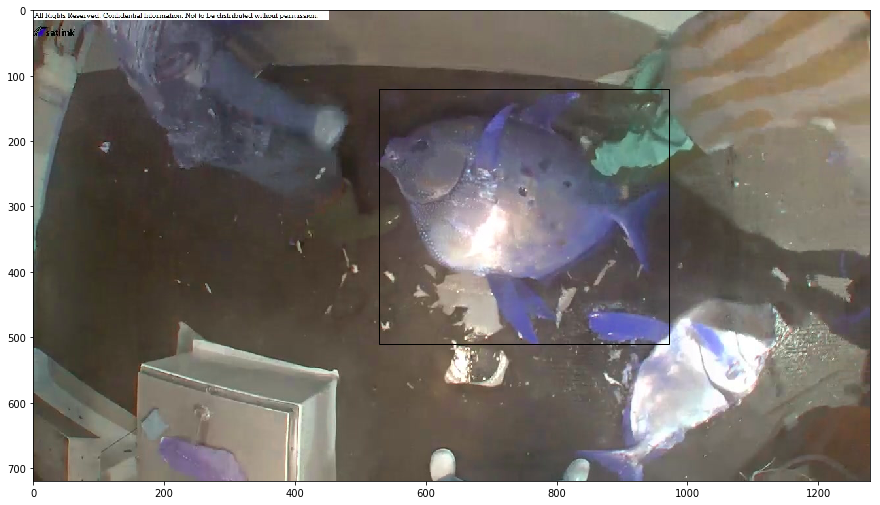

In [31]:
# log('Features', X.shape)
# log('Labels', Y.shape)
from matplotlib.patches import Rectangle

with open('annotations/lag_labels.json') as data_file:    
    annotations = json.load(data_file)
    
a = annotations[-1]['annotations'][0]
log('json', a)

x = a['x']
y = a['y']
w = a['width']
h = a['height']

path = 'input/train/LAG/img_00091.jpg'
img = cv2.imread(path)

plt.figure(figsize=(15,20))
plt.imshow(img)
axis = plt.gca()
axis.add_patch(Rectangle((x, y), w, h, fill=None))
plt.show()

# Models

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import utils

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(len(TYPES), activation='softmax')(x)

# this is the model we will train
inceptionv3 = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
inceptionv3.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
Y = utils.to_categorical(y)
inceptionv3.fit(X, Y, validation_split=0.1)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
# for i, layer in enumerate(base_model.layers):
#   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in inceptionv3.layers[:172]:
   layer.trainable = False
for layer in inceptionv3.layers[172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
inceptionv3.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
inceptionv3.fit(X, Y, validation_split=0.2)

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

img_path = 'output/train/ALB/img_00003.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
log('X', x.shape)


resnet50 = ResNet50(weights='imagenet')
preds = resnet50.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

In [ ]:
from keras.applications.inception_v3 import preprocess_input, decode_predictions

img_path = 'output/train/SHARK/img_00365.jpg'
img = image.load_img(img_path, target_size=(SIZE, SIZE))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
log('X', x.shape)

preds = inceptionv3.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
log('Predicted:', preds)
log('Predicted:', TYPES[preds.argmax()])

Train on 1877 samples, validate on 209 samples
Epoch 1/10
1877/1877 [==============================] - 83s - loss: 1.6376 - acc: 0.4901 - val_loss: 1.7200 - val_acc: 0.3445

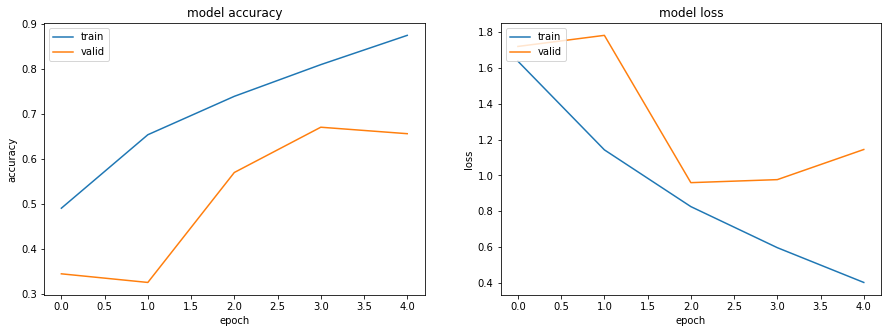

In [14]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, History

model = Sequential()

model.add(Conv2D(10, (5, 5), input_shape=X[0].shape)) # 0
model.add(Activation('relu'))
model.add(Conv2D(10, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(20, (5, 5))) # 6
model.add(Activation('relu'))
model.add(Conv2D(20, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) # 12
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_LABELS, activation='softmax')) # 16

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
YH = keras.utils.to_categorical(Y, num_classes=NUM_LABELS)
callbacks = [EarlyStopping(monitor='val_loss', patience=1, verbose=1)]
history = model.fit(X, YH, validation_split=0.1, epochs=10, callbacks=callbacks)
model.save('fisheries.h5')

# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc']); plt.plot(history.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [15]:
from keras.utils import plot_model
import vis
from vis.visualization import visualize_cam

# img = X[0]
# print(img.shape)
# heatmap = visualize_cam(model, 12, [1], img)
# plt.imshow(heatmap)
# plot_model(model, to_file='fisheries.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 146, 146, 10)      760       
_________________________________________________________________
activation_6 (Activation)    (None, 146, 146, 10)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 142, 142, 10)      2510      
_________________________________________________________________
activation_7 (Activation)    (None, 142, 142, 10)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 71, 71, 10)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 71, 71, 10)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 67, 67, 20)        5020      
__________

# Test dataset

In [84]:
T1, filenames1 = dataset.load_test1_data()
T2, filenames2 = dataset.load_test2_data()

Status: Processing... 1000 files 
Status: DONE 
Shape: (1000, 128, 128, 3) 
Size: 187.5 MB
Status: Processing... 12153 files 
Status: DONE 
Shape: (12153, 128, 128, 3) 
Size: 2278.6875 MB


In [88]:
T1.shape

(1000, 128, 128, 3)

# Prediction

In [115]:
P1 = model.predict(T1)
log('Predictions 1', P1.shape)

P2 = model.predict(T2)
log('Predictions 2', P2.shape)

Predictions 1: (1000, 8) 
Predictions 2: (12153, 8) 


In [116]:
P2[:5]

array([[  1.00303464e-01,   1.15617067e-02,   8.79039094e-02,
          1.23809390e-01,   5.02687514e-01,   1.03205685e-02,
          1.79780403e-03,   1.61615655e-01],
       [  1.15630701e-01,   5.13975683e-05,   1.83726905e-03,
          1.36137227e-04,   1.25835612e-01,   2.03721970e-03,
          2.47104047e-03,   7.52000511e-01],
       [  9.73976672e-01,   1.06474292e-02,   1.98265971e-05,
          1.53182500e-05,   1.25403656e-02,   1.21235300e-03,
          6.84795305e-05,   1.51946733e-03],
       [  9.26681399e-01,   4.55739116e-03,   7.24147307e-03,
          8.54270547e-05,   2.13714205e-02,   2.18218658e-04,
          1.75310008e-04,   3.96693945e-02],
       [  9.67046142e-01,   4.16020248e-06,   1.15375915e-04,
          5.70791417e-06,   2.28942896e-04,   3.88468878e-04,
          3.33628145e-06,   3.22077759e-02]], dtype=float32)

# Submission

In [117]:
pd1 = pd.DataFrame(columns=['image','ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT'])
pd1.image = filenames1
pd1.iloc[:,1:9] = P1

pd2 = pd.DataFrame(columns=['image','ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT'])
pd2.image = list(map(lambda n: 'test_stg2/' + n, filenames2))
pd2.iloc[:,1:9] = P2

submission = pd.concat([pd1, pd2])
print(submission.shape)
print(submission.head())

filename = 'submission-' + time.strftime("%Y%m%d%H%M", time.gmtime()) + '.csv'
submission.to_csv(filename, index=False)

(13153, 9)
           image          ALB          BET          DOL          LAG  \
0  img_00005.jpg  4.23562e-06  1.70629e-09    3.082e-10   1.1407e-09   
1  img_00007.jpg     0.998899  0.000362282  6.29423e-07  3.34296e-06   
2  img_00009.jpg     0.939842   0.00376028  2.79349e-05  1.09599e-05   
3  img_00018.jpg     0.977338  4.07318e-06  5.54595e-07  1.00834e-06   
4  img_00027.jpg     0.931249    0.0041416    0.0216974  0.000140911   

          NoF        OTHER        SHARK          YFT  
0    0.999996  1.56203e-09  2.49154e-10  3.24766e-09  
1  7.3585e-05  4.90339e-07  4.73475e-07   0.00066027  
2   0.0559795  0.000202696  5.28179e-05  0.000124069  
3  0.00014753    0.0146557  4.86957e-06   0.00784829  
4   0.0109464    0.0143763   0.00443333    0.0130154  


# References

* https://deepsense.io/deep-learning-right-whale-recognition-kaggle/
* http://matthewearl.github.io/2016/05/06/cnn-anpr/
* http://cs231n.stanford.edu/reports/2016/pdfs/285_Report.pdf
* https://www.kaggle.com/narae78/the-nature-conservancy-fisheries-monitoring/fish-detection/run/461339
* http://felixlaumon.github.io/2015/01/08/kaggle-right-whale.html
